# Estimating nuisance parameters in inverse problems

Based on 

* [Estimating nuisance parameters in inverse problems](https://iopscience.iop.org/article/10.1088/0266-5611/28/11/115016).
A.Y. Aravkin and T. van Leeuwen. Inverse Problems (28:11)

* [Variable Projection for NonSmooth Problems](https://epubs.siam.org/doi/abs/10.1137/20M1348650). T. van Leeuwen and A.Y. Aravkin. SIAM J. Sci. Comput. (accepted)

(Motivation)

# Overview

* General formulation
* Variable projection
* Examples
* Wrap-up

# General formulation

MAP estimation for inverse problems can be generally formulated as 

$$\min_u F(u) + G(u),$$

with $F(u) = -\log \pi_{\text{data}}(u)$ and  $G(u) = -\log \pi_{\text{prior}}(u)$.

The densities often include parameters $\theta$ (mean, variance, ...). This leads to 

$$\min_{u,\theta} F(u,\theta) + G(u,\theta) + H(\theta),$$

with $H(\theta) = -\log \pi_{\text{hyper}}(\theta)$.

> **Example: *Extended least-squares:***
> $$\min_{u,\Sigma} m \log |\Sigma| + \sum_{i=1}^m \|K(u) - f^\delta\|_{\Sigma^{-1}}^2.$$
> Has a closed-form solution for fixed $u$:
> $$\Sigma = \frac{1}{m}\sum_{i}^m (K(u) - f^\delta)(K(u) - f^\delta)^T.$$

> **Example: *Robust data-fitting:***
> $$\min_{u,\sigma^2} n\log\sigma + \sum_{i=1}^n \log\left(1 + \frac{r_i(u)^2}{\sigma^2}\right), \quad r = K(u) - f.$$

# Variable projection


Often, the nuisance parameters separate, and we can write

$$\min_u \underbrace{\min_\alpha F(u,\alpha)}_{\overline{F}(u)} + \underbrace{\min_\beta G(u,\beta)}_{\overline{G}(u)}.$$

and apply a proximal-gradient algorithm

$$u_{k+1} = \text{prox}_{\lambda \overline{G}} \left(u_k - \lambda \nabla \overline{F}(u)\right).$$


## Derivative formula
Assuming that $\nabla_u F$ and $\nabla_\alpha F$ are Lipschitz-continuous and $F$ is $\mu-$ strongly convex in $\alpha$ for all $u$;


* $\overline{\alpha}(u) = \text{arg}\min_\alpha F(u,\alpha)$ is Lipschitz continuous 
* $\nabla \overline{F}(u) = \left.\nabla_u F(u,\alpha)\right|_{\alpha = \overline{\alpha}(u)}.$
* an approximate minimiser $\widetilde{\alpha}(u)$ yields an approximate gradient with

$$\|\nabla F(u,\overline{\alpha}(u)) - \nabla F(u,\widetilde{\alpha}(u))\| \leq L_{u\alpha} \|\overline{\alpha}(u) -\widetilde{\alpha}(u)\|.$$

## Proximal operator

## Convergence results

(Schmidt, Mark, Nicolas Le Roux, and Francis Bach. "Convergence rates of inexact proximal-gradient methods for convex optimization." NeurIps (2011).)

# Examples

## Tikhonov regularisation

Given $K \in \mathbb{R}^{m\times n}$,

$$\min_{u,\alpha,\beta} \alpha \|Ku - f^\delta\|_2^2 + \beta \|u\|_2^2 - m \log \alpha - n\log\beta.$$

* $\overline{\alpha}(u) = m/ \|Ku - f^\delta\|_2^2$, $\overline{\beta}(u) = n/ \|u\|_2^2.$

In [79]:
import numpy as np
from scipy.optimize import minimize
from skimage.color import rgb2gray
from skimage import data
from scipy.fft import fft2, ifft2
import matplotlib.pyplot as plt


def K(inp,psf=[],mode='forward'):
    N = inp.shape[0]
    n = int(np.sqrt(N))
    k_hat = fft2(psf,s=(n,n))
    inp_hat = fft2(inp.reshape((n,n)))
    if mode == 'forward':
        outp = ifft2(k_hat * inp_hat)
    if mode == 'adjoint':
        outp = ifft2(np.conj(k_hat) * inp_hat)
        
    return np.real(outp).flatten()

def val(u, *args):
    f, psf, reg = args
    n = len(u)
    m = len(f)
    Ku = K(u,psf=psf)
    Lu = K(u,psf=reg)
    
    alpha = m/np.linalg.norm(Ku - f)**2
    beta = n/np.linalg.norm(Lu)**2
    
    return m - m*np.log(alpha) + n - n*np.log(beta)
    #return np.linalg.norm(Ku - f)**2 + np.linalg.norm(Lu)**2
def grad(u, *args):
    f, psf, reg = args
    n = len(u)
    m = len(f)
    Ku = K(u,psf=psf)
    Lu = K(u,psf=reg)
    
    alpha = m/np.linalg.norm(Ku - f)**2
    beta = n/np.linalg.norm(Lu)**2
    
    return 2*alpha*K(Ku - f,psf=psf,mode='adjoint') + 2*beta*K(Lu,psf=reg,mode='adjoint')
    #return 2*K(Ku - f,psf=psf,mode='adjoint') + 2*K(Lu,psf=reg,mode='adjoint')

def plot_images(images, titles, fname=[], scale = [0,1]):
    m = len(images)
    fig, ax = plt.subplots(1,m)
    
    if m > 1:
        for k in range(m):
            ax[k].set_xticks([])
            ax[k].set_yticks([])
            N = len(images[0])
            n = int(np.sqrt(N))
            ax[k].imshow(images[k].reshape((n,n)), cmap=plt.cm.gray, vmin=scale[0], vmax=scale[1])
            ax[k].set_title(titles[k])
    else:
        ax.set_xticks([])
        ax.set_yticks([])
        N = len(images[0])
        n = int(np.sqrt(N))
        ax.imshow(images[0].reshape((n,n)), cmap=plt.cm.gray, vmin=scale[0], vmax=scale[1])
        ax.set_title(titles[0])
    fig.set_figwidth(10)
    fig.tight_layout()
    
    if fname:
        plt.savefig(fname,dpi=300)

0.3749930250504879
5.686950091855512e-15


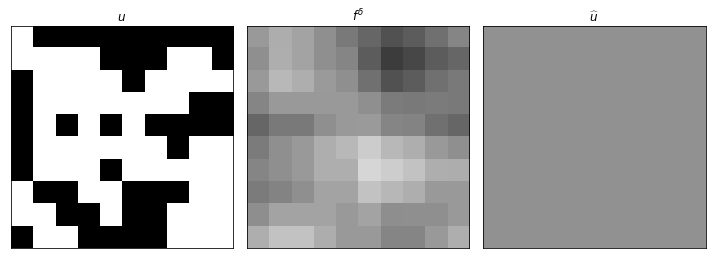

In [101]:
## settings
n = 10
sigma = 1e-3
psf = np.ones((5, 5)) / 25
reg = np.array([[0,1,0],[1,-4,1],[0,1,0]])
                
# ground truth and data
u = np.float32(data.binary_blobs(n)).flatten()
f_delta = K(u,psf=psf) + sigma*np.random.randn(n*n)

# solve
u0 = K(f_delta, psf=psf, mode = 'adjoint')
opt = {}
opt['maxiter'] = 1000
result = minimize(val, u0, args = (f_delta,psf,reg), method = 'CG', jac = grad, tol = 1e-3, options=opt)
u_hat = result.x

print(np.linalg.norm(K(u_hat,psf=psf) - f_delta)/np.sqrt(n))
print(np.linalg.norm(K(u_hat,psf=reg))/np.sqrt(n))

# plot
plot_images([u,f_delta,u_hat],['$u$','$f^\delta$','$\widehat{u}$'], fname='./figures/tikhonov1.png')

In [94]:
result

     fun: -34632.987796153495
     jac: array([-344.05966721,  131.39991817, -311.77184216, ..., -556.24399549,
        246.44360788,  -90.45010898])
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 1502
     nit: 1000
    njev: 1502
  status: 1
 success: False
       x: array([0.41690865, 0.41505663, 0.41370467, ..., 0.4181777 , 0.41490983,
       0.41231069])

![](./figures/tikhonov1.png)

## Compressed sensing

## Robust data-fitting

## Graphical lasso

# Wrap-up

* ...
* ...